In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import block_diag
import cvxpy as cp

import networkx as nx

from numpy.linalg import inv, pinv

$$ 
\begin{align*}
    \min_{x_n \in X_n, \ n \in N} & \sum\limits_{n=1}^{N} f_n(x_n) \\
    \textrm{s.t.} & \sum\limits_{n=1}^{N} A_n x_n = b
\end{align*}
$$

$$ 
\begin{align*}
    \min_{\bm{x} \in X} & f(\bm{x}) \\
    \textrm{s.t.} & \bm{A} \bm{x} = b
\end{align*}
$$

$$ 
f(\bm{x}) = \bm{x}^\top \bm{C} \bm{x} + \bm{q}^\top \bm{x} 
$$

In [70]:
np.random.seed(37)

N = 50 # number of agents
H = 20 # dim x_n
M = 20 # dim b

#C = np.random.randint(low=100, size=(N*H, N*H))
#C = C.T @ C + 100 * np.identity(N*H)
C = np.identity(N*H)
q = np.random.randint(low=100, size=N*H)

A_array = []

for n in range(N):
    #A_n = np.random.randint(low=100, size=(M, H))
    A_n = np.ones((M, H))
    A_array.append(A_n)

A_array = np.array(A_array)

A = np.hstack(A_array)
#b = np.random.randint(low=100, size=M)
b = np.zeros(M)

alpha = 1

Q_array = []

for n in range(N):
    Q_n = alpha * (N - 1) * (A_array[n].T @ A_array[n]) + 100 * np.identity(H)
    #print(np.all(np.linalg.eigvals(Q_n) > 0))
    Q_array.append(Q_n)

Q_array = np.array(Q_array)

In [71]:
def f(x):
    return x @ C @ x + q @ x

In [72]:
def Proj(x):
    y = np.empty_like(x)
    for i in range(len(x)):
        if x[i] < -1:
            y[i] = -1
        elif -1 <= x[i] <= 1:
            y[i] = x[i]
        elif x[i] > 1:
            y[i] = 1
    return y

In [73]:
def newton(theta_0: np.ndarray, n_iters: int, F, grad_F, hess_F):
    #flog = []
    theta = theta_0
    hessian = hess_F(theta)
    pinv_hessian = inv(hessian)
    for _ in range(n_iters):
        #flog.append(F(theta))
        theta = Proj(theta - pinv_hessian @ grad_F(theta))
    return theta

In [74]:
def MetropolisWeights(E):
    d = E.sum(axis=1)
    W = np.zeros_like(E)
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            if i == j:
                continue
            else:
                if E[i, j] == 1:
                    W[i, j] = 1 / (1 + max(d[i], d[j]))
                else:
                    W[i, j] = 0
        W[i, i] = 1 - W[i].sum()
    return W

# Solving via CVXPY

In [75]:
x = cp.Variable(N*H)

func = cp.quad_form(x, C) + q @ x

constraints = [A @ x == b,
               x >= -1,
               x <= 1]


obj = cp.Minimize(func)

prob = cp.Problem(obj, constraints)
prob.solve()
x_opt = x.value
lambda_opt = constraints[0].dual_value

# Algorithm

In [76]:
def PJ_ADMM_LC(x0, l0, n_iter, P, tau, alpha, Q_array):

    A_hat = block_diag(*A_array)
    b_hat = np.kron(np.ones(N), b)
    P_Ntau = np.kron(np.linalg.matrix_power(P, tau), np.identity(M))
    I_NM = np.identity(N*M)
    Q = block_diag(*Q_array)

    x_k = np.zeros((n_iter, N*H))
    l_k = np.zeros((n_iter, N*M))

    x_k[0] = x0
    l_k[0] = l0

    k = 0

    while k <= n_iter-2:

        def F(x):
            return f(x) + alpha / 2 * np.linalg.norm(A_hat @ x + (N * P_Ntau - I_NM) @ A_hat @ x_k[k] - b_hat + P_Ntau @ l_k[k] / alpha) ** 2 + 1 / 2 * (x - x_k[k]) @ Q @ (x - x_k[k])

        def grad_F(x):
            return (2*C + Q + alpha * A_hat.T @ A_hat) @ x + q + alpha * A_hat.T @ ((N * P_Ntau - I_NM) @ A_hat @ x_k[k] - b_hat + P_Ntau @ l_k[k] / alpha) - Q @ x_k[k]
        
        def hess_F(x):
            return 2*C + Q + alpha * A_hat.T @ A_hat

        x_k[k+1] = newton(x_k[k], 1, F, grad_F, hess_F)

        l_k[k+1] = P_Ntau @ l_k[k] + alpha * (P_Ntau @ A_hat @ x_k[k] - b_hat)

        k = k + 1

    return x_k, l_k

# Ring

In [77]:
G = nx.cycle_graph(N) # creating a graph
E = nx.to_numpy_array(G) # adjacency matrix

#for i, row in enumerate(E):
#    for j, element in enumerate(row):
#        E[i, j] *= N - abs(j - i)

In [78]:
x0 = np.zeros(N*H)
l0 = np.zeros(N*H)
n_iter = 500
P = MetropolisWeights(E)

x_k_10, l_k_10 = PJ_ADMM_LC(x0, l0, n_iter, P, 10, alpha, Q_array)
x_k_5, l_k_5 = PJ_ADMM_LC(x0, l0, n_iter, P, 5, alpha, Q_array)

Text(0, 0.5, '$\\| x_i^k - x^* \\|$')

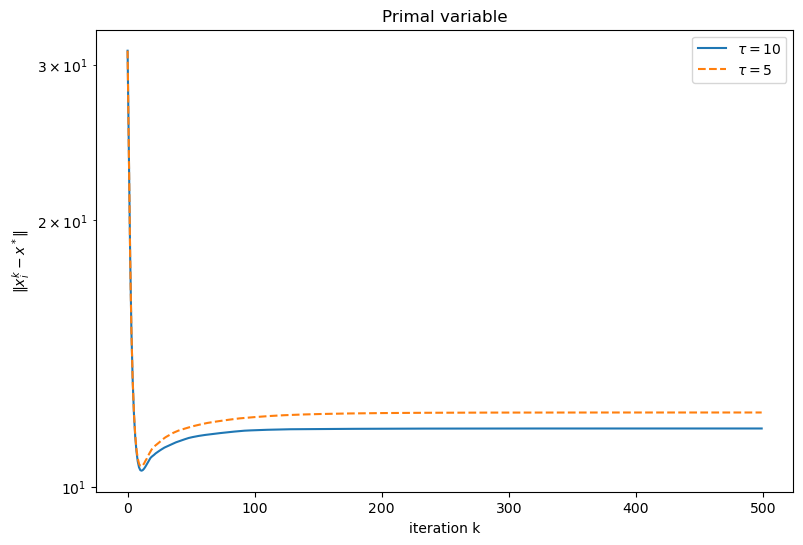

In [79]:
plt.figure(figsize=(9, 6))

plt.plot(range(x_k_10.shape[0]), [np.linalg.norm(x_k_10[k] - x_opt) for k in range(x_k_10.shape[0])], label="$\\tau = 10$")
plt.plot(range(x_k_5.shape[0]), [np.linalg.norm(x_k_5[k] - x_opt) for k in range(x_k_5.shape[0])], '--', label="$\\tau = 5$")

plt.yscale('log')
plt.legend()
plt.title("Primal variable")
plt.xlabel("iteration k")
plt.ylabel("$\| x_i^k - x^* \|$")
#plt.xlim(0, 30)

Text(0, 0.5, '$\\| \\lambda_i^k - \\lambda^* \\|$')

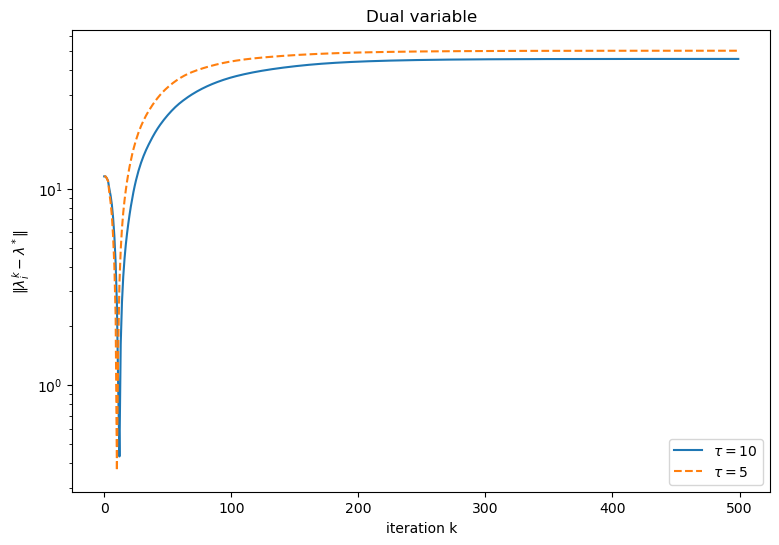

In [80]:
plt.figure(figsize=(9, 6))

plt.plot(range(l_k_10.shape[0]), [np.linalg.norm(l_k_10[k][:20] - lambda_opt) for k in range(l_k_10.shape[0])], label="$\\tau = 10$")
plt.plot(range(l_k_5.shape[0]), [np.linalg.norm(l_k_5[k][:20] - lambda_opt) for k in range(l_k_5.shape[0])], '--', label="$\\tau = 5$")
    
plt.yscale('log')
plt.legend()
plt.title("Dual variable")
plt.xlabel("iteration k")
plt.ylabel("$\| \lambda_i^k - \lambda^* \|$")

Text(0, 0.5, 'objective value $|f(x) - f(x^*) / f(x^*)|$')

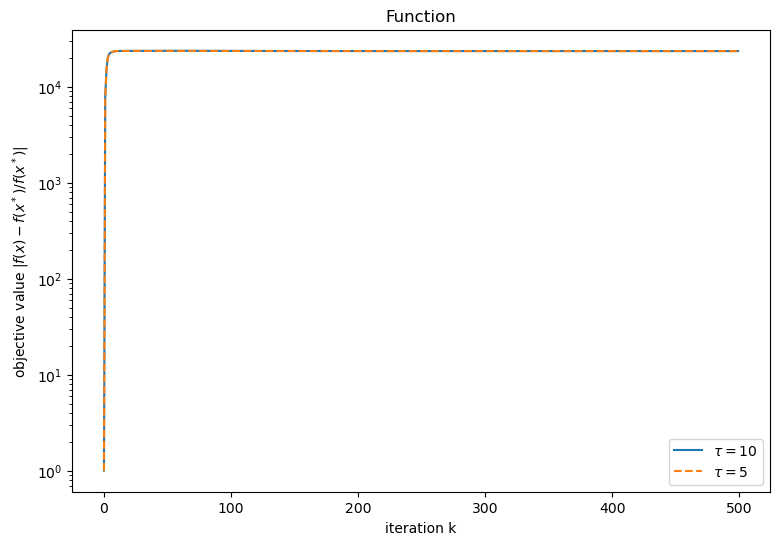

In [81]:
plt.figure(figsize=(9, 6))

plt.plot(range(x_k_10.shape[0]), [abs(f(x_k_10[k]) - f(x_opt) / f(x_opt)) for k in range(x_k_10.shape[0])], label="$\\tau = 10$")
plt.plot(range(x_k_5.shape[0]), [abs(f(x_k_5[k]) - f(x_opt) / f(x_opt)) for k in range(x_k_5.shape[0])], '--', label="$\\tau = 5$")

plt.yscale('log')
plt.legend()
plt.title("Function")
plt.xlabel("iteration k")
plt.ylabel("objective value $|f(x) - f(x^*) / f(x^*)|$")

# Small world network

In [319]:
k = 10   # number of links per each node
p = 0.2 # probability of adding a "short" path
G = nx.connected_watts_strogatz_graph(N, k, p) # creating a graph
E = nx.to_numpy_array(G) # adjacency matrix

#for i, row in enumerate(E):
#    for j, element in enumerate(row):
#        E[i, j] *= N - abs(j - i)

In [320]:
x0 = np.zeros(N*H)
l0 = np.zeros(N*H)
n_iter = 500
P = MetropolisWeights(E)

x_k_10, l_k_10 = PJ_ADMM_LC(x0, l0, n_iter, P, 10, alpha, Q_array)
x_k_5, l_k_5 = PJ_ADMM_LC(x0, l0, n_iter, P, 5, alpha, Q_array)

Text(0, 0.5, '$\\| x_i^k - x^* \\|$')

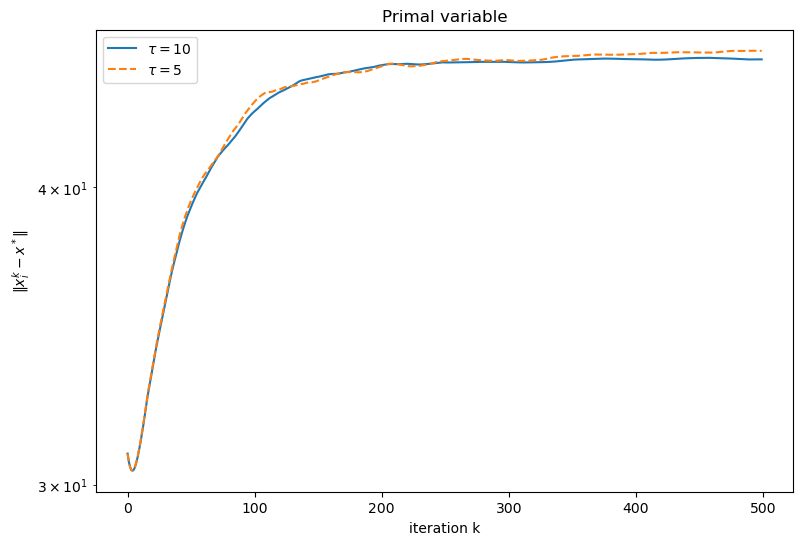

In [321]:
plt.figure(figsize=(9, 6))

plt.plot(range(x_k_10.shape[0]), [np.linalg.norm(x_k_10[k] - x_opt) for k in range(x_k_10.shape[0])], label="$\\tau = 10$")
plt.plot(range(x_k_5.shape[0]), [np.linalg.norm(x_k_5[k] - x_opt) for k in range(x_k_5.shape[0])], '--', label="$\\tau = 5$")

plt.yscale('log')
plt.legend()
plt.title("Primal variable")
plt.xlabel("iteration k")
plt.ylabel("$\| x_i^k - x^* \|$")

Text(0, 0.5, '$\\| \\lambda_i^k - \\lambda^* \\|$')

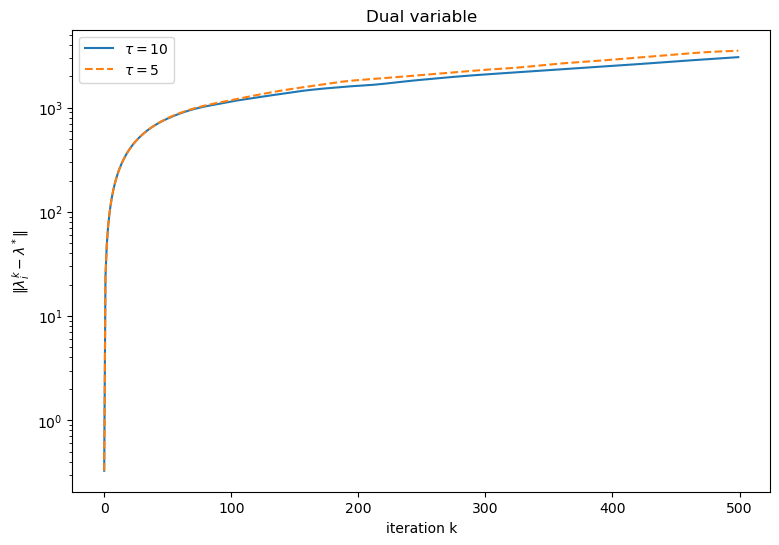

In [322]:
plt.figure(figsize=(9, 6))

plt.plot(range(l_k_10.shape[0]), [np.linalg.norm(l_k_10[k][:20] - lambda_opt) for k in range(l_k_10.shape[0])], label="$\\tau = 10$")
plt.plot(range(l_k_5.shape[0]), [np.linalg.norm(l_k_5[k][:20] - lambda_opt) for k in range(l_k_5.shape[0])], '--', label="$\\tau = 5$")
    
plt.yscale('log')
plt.legend()
plt.title("Dual variable")
plt.xlabel("iteration k")
plt.ylabel("$\| \lambda_i^k - \lambda^* \|$")

Text(0, 0.5, 'objective value $|f(x) - f(x^*) / f(x^*)|$')

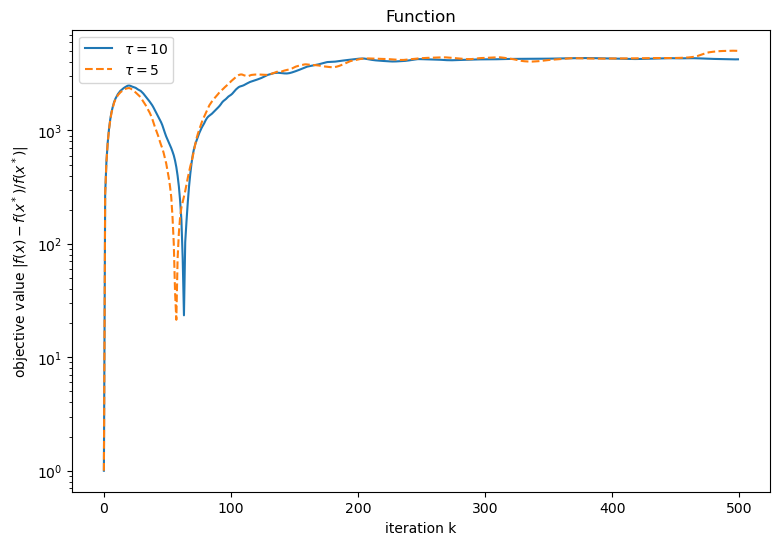

In [323]:
plt.figure(figsize=(9, 6))

plt.plot(range(x_k_10.shape[0]), [abs(f(x_k_10[k]) - f(x_opt) / f(x_opt)) for k in range(x_k_10.shape[0])], label="$\\tau = 10$")
plt.plot(range(x_k_5.shape[0]), [abs(f(x_k_5[k]) - f(x_opt) / f(x_opt)) for k in range(x_k_5.shape[0])], '--', label="$\\tau = 5$")

plt.yscale('log')
plt.legend()
plt.title("Function")
plt.xlabel("iteration k")
plt.ylabel("objective value $|f(x) - f(x^*) / f(x^*)|$")